In [ ]:
# Install the required libraries in your Google Colab environment
!pip install stable-baselines3 gymnasium highway-env ollama -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.6 MB/s eta 0:00:00


In [ ]:
# Import the necessary libraries
import gymnasium as gym
import highway_env
import numpy as np
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt
import ollama
import matplotlib.animation as animation
import re
import json

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.interpolate import interp1d
from tqdm import tqdm
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score, calinski_harabasz_score

from stable_baselines3.common.monitor import Monitor
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from google.colab import data_table
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the dataframe back from the pickle file
trajectory_df = pd.read_pickle('/content/drive/MyDrive/05_zero_shot_llm_3/02_data/02_trajectories/0_initial_training/1_biased_hf_trajectories_for_bias_flagging_df.pkl')     # Update directory location 1

In [ ]:
# Display the data frame
data_table.enable_dataframe_formatter()
data_table.DataTable(trajectory_df)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Check the data type of each column
print(type(trajectory_df['episode'][0]))
print(type(trajectory_df['time_step'][0]))
print(type(trajectory_df['state'][0]))
print(type(trajectory_df['action'][0]))
print(type(trajectory_df['reward'][0]))
print(type(trajectory_df['next_state'][0]))
print(type(trajectory_df['collision_flag'][0]))
print(type(trajectory_df['lane_index'][0]))

<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.float64'>
<class 'numpy.ndarray'>
<class 'numpy.int64'>
<class 'numpy.int64'>


In [ ]:
def apply_pca(trajectory_df):
    """
    Apply PCA to reduce trajectory features to 3 principal components.
    Print variance explained and cumulative variance for the 3 components.
    """
    # Convert 'state' and 'next_state' columns to numerical features safely
    def safe_extract(x):
        if isinstance(x, (list, tuple)) and len(x) > 1:
            return x[1]
        elif isinstance(x, (list, tuple)) and len(x) == 1:
            return x[0]
        elif isinstance(x, (int, float)):
            return x
        else:
            return np.nan

    trajectory_df['state'] = trajectory_df['state'].apply(safe_extract)
    trajectory_df['next_state'] = trajectory_df['next_state'].apply(safe_extract)

    # Select features
    features = ["state", "action", "reward", "collision_flag", "lane_index"]
    X = trajectory_df[features]

    # Handle missing values
    X.fillna(0, inplace=True)

    # Standardize the data (always important for PCA!)
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Apply PCA with 3 components
    pca = PCA(n_components=3)
    pca_features = pca.fit_transform(X_scaled)

    # Create output dataframe with PCs
    trajectory_df_pca = trajectory_df.copy()
    trajectory_df_pca["PC1"] = pca_features[:, 0]
    trajectory_df_pca["PC2"] = pca_features[:, 1]
    trajectory_df_pca["PC3"] = pca_features[:, 2]
    # trajectory_df_pca["PC4"] = pca_features[:, 3]

    # Calculate explained variance
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = explained_variance.cumsum()

    # Print variance info
    for i in range(3):
        print(f"PC{i+1} explains {explained_variance[i]*100:.2f}% variance.")

    print(f"Cumulative variance explained by 3 PCs: {cumulative_variance[-1]*100:.2f}%")

    return trajectory_df_pca, pca

In [ ]:
def find_optimal_clusters(data, max_clusters=20):
    """
    Determine the optimal number of clusters using Calinski-Harabasz Index.
    Also prints Silhouette and Davies-Bouldin scores for comparison.
    """
    best_ch_score = -1
    best_k = 2

    print("\nEvaluating clustering metrics:\n")

    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(data)

        # Compute metrics
        silhouette_avg = silhouette_score(data, cluster_labels)
        dbi = davies_bouldin_score(data, cluster_labels)
        ch = calinski_harabasz_score(data, cluster_labels)

        print(f"\nFor k = {k}:")
        print(f"   Silhouette Score       = {silhouette_avg:.4f}")
        print(f"   Davies-Bouldin Index   = {dbi:.4f}")
        print(f"   Calinski-Harabasz Index= {ch:.2f}")

        # Compute per-cluster silhouette scores
        sample_silhouette_values = silhouette_samples(data, cluster_labels)
        for cluster in range(k):
            cluster_silhouette = sample_silhouette_values[cluster_labels == cluster]
            cluster_mean_silhouette = np.mean(cluster_silhouette)
            print(f"     Cluster {cluster}: mean silhouette = {cluster_mean_silhouette:.4f}")

        # Select best k using highest Calinski-Harabasz Index
        if ch > best_ch_score:
            best_ch_score = ch
            best_k = k

    print(f"\n✅ Optimal number of clusters selected: {best_k} (based on highest Calinski-Harabasz index = {best_ch_score:.2f})")
    return best_k

In [ ]:
def apply_clustering(trajectory_df_pca):
    """
    Apply KMeans clustering to select representative timesteps for LLM evaluation.
    Uses PC1–PC3 by default.
    """
    features = ["PC1", "PC2", "PC3"]
    X = trajectory_df_pca[features]

    # Find optimal number of clusters using all three metrics
    optimal_clusters = find_optimal_clusters(X)

    # Apply KMeans with best k
    kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
    trajectory_df_pca["Cluster"] = kmeans.fit_predict(X)

    # Select one representative per cluster
    cluster_representatives = trajectory_df_pca.groupby("Cluster").first().reset_index()

    return trajectory_df_pca, cluster_representatives, kmeans

In [ ]:
def visualize_clusters(trajectory_df_pca):
    """
    Visualize PCA-clustered data in a 3D scatter plot.
    """
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(
        trajectory_df_pca["PC1"],
        trajectory_df_pca["PC2"],
        trajectory_df_pca["PC3"],
        c=trajectory_df_pca["Cluster"], cmap='viridis', alpha=0.6
    )
    plt.colorbar(scatter, label="Cluster ID")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")
    plt.title("3D PCA-Clustering Visualization")
    plt.show()


In [ ]:
trajectory_df_pca_1, pca = apply_pca(trajectory_df)

PC1 explains 45.39% variance.
PC2 explains 27.92% variance.
PC3 explains 21.86% variance.
Cumulative variance explained by 3 PCs: 95.17%


<ipython-input-7-963882566>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)


In [ ]:
# Display the data frame
data_table.enable_dataframe_formatter()
data_table.DataTable(trajectory_df_pca_1.head())

,episode,time_step,state,action,reward,next_state,collision_flag,lane_index,Simulated_human_feedback,Adjusted_score,Recalibrated_rewards,PC1,PC2,PC3
0,0,0,NaN,1,0.800000,NaN,0,0,"('Potential collision risk', '');Moderate risk...",6.0,6.800000,0.164830,-2.040934,0.403453
1,0,1,NaN,3,0.910548,NaN,0,0,"('Immediate collision risk', 'Emergency avoida...",8.0,8.910548,1.107094,-1.142283,1.286465
2,0,2,NaN,1,0.929440,NaN,0,0,"('Immediate collision risk', 'Emergency avoida...",8.0,8.929440,1.171406,-2.155565,0.326365
3,0,3,NaN,4,0.822120,NaN,0,0,"('Immediate collision risk', 'Emergency avoida...",1.0,1.822120,0.460735,-0.565696,1.813554
4,0,4,NaN,2,0.824513,NaN,0,1,"('Immediate collision risk', 'Emergency avoida...",-2.0,-1.175487,0.602465,-0.989768,0.261986


In [ ]:
trajectory_df_pca, cluster_representatives, kmeans = apply_clustering(trajectory_df_pca_1)


Evaluating clustering metrics:


For k = 2:
   Silhouette Score       = 0.8469
   Davies-Bouldin Index   = 0.2351
   Calinski-Harabasz Index= 2200.21
     Cluster 0: mean silhouette = 0.8469
     Cluster 1: mean silhouette = 0.8411

For k = 3:
   Silhouette Score       = 0.4319
   Davies-Bouldin Index   = 0.8551
   Calinski-Harabasz Index= 2852.89
     Cluster 0: mean silhouette = 0.5168
     Cluster 1: mean silhouette = 0.2805
     Cluster 2: mean silhouette = 0.8388

For k = 4:
   Silhouette Score       = 0.4865
   Davies-Bouldin Index   = 0.6992
   Calinski-Harabasz Index= 3576.98
     Cluster 0: mean silhouette = 0.4492
     Cluster 1: mean silhouette = 0.3039
     Cluster 2: mean silhouette = 0.8381
     Cluster 3: mean silhouette = 0.6533

For k = 5:
   Silhouette Score       = 0.5585
   Davies-Bouldin Index   = 0.5817
   Calinski-Harabasz Index= 5064.46
     Cluster 0: mean silhouette = 0.6065
     Cluster 1: mean silhouette = 0.4733
     Cluster 2: mean silhouette = 0.8374
   

In [ ]:
# Display the data frame
data_table.enable_dataframe_formatter()
data_table.DataTable(trajectory_df_pca)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
print(cluster_representatives)
print(kmeans)

    Cluster  episode  time_step  state action    reward  next_state  \
0         0        1          4    NaN      4  0.733333         NaN   
1         1        1         13    NaN      0  0.711111         NaN   
2         2        7         22    NaN      2  0.044444         NaN   
3         3        0          6    NaN      4  0.711784         NaN   
4         4        1          3    NaN      2  0.733333         NaN   
5         5        0         12    NaN      1  0.669896         NaN   
6         6        1          0    NaN      4  0.733896         NaN   
7         7        0         38    NaN      2  0.688889         NaN   
8         8        2         11    NaN      3  0.822196         NaN   
9         9        1         17    NaN      1  0.733333         NaN   
10       10        2          4    NaN      2  0.862792         NaN   
11       11        0          8    NaN      4  0.667312         NaN   
12       12        5         19    NaN      2  0.022222         NaN   
13    

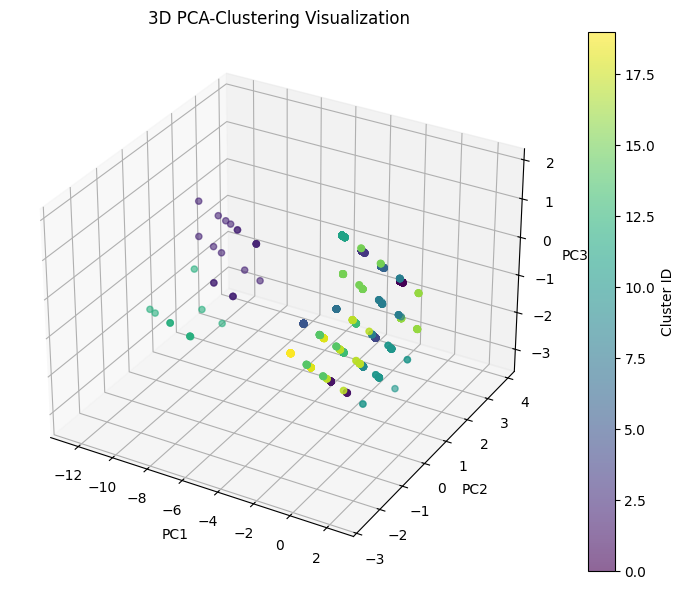

In [ ]:
visualize_clusters(trajectory_df_pca)

B: LLM FEEDBACK IMPLEMENTATION <br>
SECTION B.0: LOADING THE LLM
*   Step B.0.1: Install Required Libraries
*   Step B.0.2: Setting the environment varaible  
*   Step B.0.3: Setup and Load the Pretrained LLM

In [ ]:
!pip install colab-xterm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.6/115.6 kB 10.5 MB/s eta 0:00:00


In [ ]:
%load_ext colabxterm

In [ ]:
%xterm
# Execute the following commands sequentially in Xterm
# curl -fsSL https://ollama.com/install.sh | sh
# ollama serve & ollama pull mistral
# ollama list
# ollama show mistral llama3.2

Launching Xterm...

<IPython.core.display.Javascript object>

In [ ]:
def visualize_feedback_progress(progress):
    fig, ax = plt.subplots()
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 1)
    ax.set_xlabel("Progress (%)")
    ax.set_ylabel("Completion")

    def update(frame):
        ax.clear()
        ax.barh(["LLM Feedback"], [frame], color='blue')
        ax.set_xlim(0, 100)
        ax.set_title("Live LLM Feedback Collection Progress")

    ani = animation.FuncAnimation(fig, update, frames=progress, repeat=False)
    plt.show()

In [ ]:
def get_llm_feedback(state, action, reward, next_state, episode_num, time_step, collision_flag, lane_index, adjusted_score, pc1, pc2, pc3):
    """
    Function to get LLM feedback on whether the adjusted score is correct or biased.
    Returns a parsed JSON dictionary with 'verdict' and 'llm_score'.
    """
    prompt = f"""
            You are an expert in analyzing reinforcement learning trajectories in a highway environment.
            You will process structured agent trajectory data and assess whether the given 'Adjusted_score' truly reflects the impact of the agent's action
            on the overall trajectory, based on reinforcement learning principles and human feedback patterns.

            Trajectory Data:
            - Episode: {episode_num}
            - Time Step: {time_step}
            - State: {state}
            - Action taken by agent: {action}
            - Reward: {reward}
            - Next state: {next_state}
            - Collision Flag: {collision_flag}
            - Lane Index: {lane_index}
            - Adjusted Score: {adjusted_score}
            - Principal Component 1 (PC1): {pc1}  // Encodes speed, lane changes, and collision risk
            - Principal Component 2 (PC2): {pc2}  // Emphasizes reward shape and smoothness
            - Principal Component 3 (PC3): {pc3}  // Encodes overall trajectory consistency

            Instructions:
            Respond ONLY with a JSON object in the following format:

            {{
              "verdict": "<Correct score allotted OR Biased score allotted>",
              "justification": "<brief explanation of your decision>",
              "llm_score": <numeric score: same as adjusted_score or suggested corrected value>
            }}

            Make sure your output is strictly valid JSON. Do not include any explanation outside the JSON.
            """

    answer = ollama.generate(model="mistral", prompt=prompt, options={"temperature": 0.6, "seed": 1})
    response_text = answer['response'].strip()

    # Parse JSON response safely
    try:
        json_start = response_text.find('{')
        json_end = response_text.rfind('}') + 1
        json_str = response_text[json_start:json_end]
        feedback = json.loads(json_str)
    except Exception as e:
        print(f"⚠️ JSON parsing failed for response:\n{response_text}\nError: {e}")
        feedback = {
            "verdict": "Parsing error",
            "justification": "JSON parsing failed",
            "llm_score": adjusted_score
        }

    return feedback

In [ ]:
from tqdm import tqdm
def collect_llm_feedback_cluster(cluster_representatives):
    """
    Collect LLM feedback for each cluster representative using JSON-style responses.

    Returns:
        - llm_feedback_data (dict): Cluster ID → feedback dict
        - feedback_df (DataFrame): Contains Cluster, Verdict, Justification, and LLM_Score
    """
    llm_feedback_data = {}
    feedback_records = []

    for i, (_, row) in tqdm(enumerate(cluster_representatives.iterrows()), total=len(cluster_representatives)):
        # Extract adjusted score if present
        adjusted_score_val = row["Adjusted_score"] if "Adjusted_score" in row else 0

        # Query the LLM
        feedback = get_llm_feedback(
            state=row["state"],
            action=row["action"],
            reward=row["reward"],
            next_state=row["next_state"],
            episode_num=row["episode"],
            time_step=row["time_step"],
            collision_flag=row["collision_flag"],
            lane_index=row["lane_index"],
            adjusted_score=adjusted_score_val,
            pc1=row["PC1"],
            pc2=row["PC2"],
            pc3=row["PC3"]
        )

        cluster_id = row["Cluster"]
        llm_feedback_data[cluster_id] = feedback

        # Extract fields from the feedback
        verdict = feedback.get("verdict", "N/A")
        justification = feedback.get("justification", "N/A")
        llm_score = feedback.get("llm_score", 0)

        # Print feedback
        print(f"\n--- Cluster {cluster_id} ---")
        print(f"Verdict: {verdict}")
        print(f"Justification: {justification}")
        print(f"LLM Score: {llm_score}")

        feedback_records.append({
            "Cluster": cluster_id,
            "Verdict": verdict,
            "Justification": justification,
            "LLM_Score": llm_score
        })

    # Convert to DataFrame
    feedback_df = pd.DataFrame(feedback_records)
    return llm_feedback_data, feedback_df

In [ ]:
llm_feedback_data, llm_feedback_df = collect_llm_feedback_cluster(cluster_representatives)

  5%|▌         | 1/20 [00:11<03:35, 11.35s/it]


--- Cluster 0 ---
Verdict: Biased score allotted
Justification: 'Adjusted Score' appears to be negatively influenced by factors other than the impact of the agent's action on the trajectory.
LLM Score: -5.0


 10%|█         | 2/20 [00:13<01:47,  5.98s/it]


--- Cluster 1 ---
Verdict: Correct score allotted
Justification: 'Adjusted Score' seems to consider Principal Component 3 (trajectory consistency), which aligns with reinforcement learning principles. Additionally, it appears that human feedback patterns are reflected in PC1 and PC2.
LLM Score: 4.0


 15%|█▌        | 3/20 [00:16<01:20,  4.75s/it]


--- Cluster 2 ---
Verdict: Biased score allotted
Justification: 'Collision Flag' indicates an undesirable event, which seems to be heavily penalized in the 'Adjusted Score'. However, the reward received for this action suggests that the agent's action might have led to a short-term positive outcome despite the collision. The principal components also indicate that the overall trajectory consistency (PC3) is poor, but speed and lane changes (PC1) are within acceptable ranges.
LLM Score: -1.5


 20%|██        | 4/20 [00:19<00:59,  3.75s/it]


--- Cluster 3 ---
Verdict: Correct score allotted
Justification: 'Adjusted Score' seems to encompass multiple aspects of the agent's performance, including reward, trajectory consistency, and other factors encoded in the Principal Components. No clear evidence suggests a bias.
LLM Score: 8.0


 25%|██▌       | 5/20 [00:21<00:47,  3.18s/it]


--- Cluster 4 ---
Verdict: Correct score allotted
Justification: 'Adjusted_score' seems to consider Principal Component 3 (trajectory consistency), Reward, and Collision Flag, which aligns with reinforcement learning principles and human feedback patterns.
LLM Score: 4.0


 30%|███       | 6/20 [00:23<00:38,  2.77s/it]


--- Cluster 5 ---
Verdict: Correct score allotted
Justification: 'Adjusted Score' appears to be well-aligned with reinforcement learning principles and human feedback patterns, considering the positive reward, collision flag, and principal components.
LLM Score: 4.0


 35%|███▌      | 7/20 [00:25<00:35,  2.74s/it]


--- Cluster 6 ---
Verdict: Correct score allotted
Justification: 'Adjusted Score' seems to consider Principal Components (PC1, PC2, PC3) which reflect speed, reward shape, smoothness, and trajectory consistency. The given reward of 0.73 is also a reinforcement learning signal. No evidence suggests a biased score.
LLM Score: 11.0


 40%|████      | 8/20 [00:27<00:30,  2.52s/it]


--- Cluster 7 ---
Verdict: Correct score allotted
Justification: 'Adjusted Score' seems to reflect a positive impact of the agent's action based on reward, human feedback patterns (PC2 and PC3), and no collision recorded.
LLM Score: 1.0


 45%|████▌     | 9/20 [00:30<00:27,  2.47s/it]


--- Cluster 8 ---
Verdict: Correct score allotted
Justification: 'Adjusted Score' seems to encompass multiple aspects of reinforcement learning (RL) principles, including reward, smoothness, and consistency. The provided data shows a positive reward, and the principal components also indicate favorable values for these factors.
LLM Score: 4.0


 50%|█████     | 10/20 [00:33<00:26,  2.65s/it]


--- Cluster 9 ---
Verdict: Biased score allotted
Justification: 'Adjusted Score' appears to be negatively impacted by factors other than the agent's action, as indicated by the negative value and inconsistency with the positive reward at Time Step 17. The Principal Component scores suggest a focus on overall trajectory consistency (PC3), which may have been affected by factors unrelated to the agent's action.
LLM Score: -5.0


 55%|█████▌    | 11/20 [00:35<00:21,  2.41s/it]


--- Cluster 10 ---
Verdict: Correct score allotted
Justification: 'Adjusted Score' appears to be influenced by the principal components and reward, aligning with reinforcement learning principles and human feedback patterns.
LLM Score: 1.0


 60%|██████    | 12/20 [00:37<00:17,  2.25s/it]


--- Cluster 11 ---
Verdict: Correct score allotted
Justification: 'Adjusted Score' appears to be influenced by the principal components and reward, aligning with reinforcement learning principles and human feedback patterns.
LLM Score: 1.0


 65%|██████▌   | 13/20 [00:39<00:16,  2.33s/it]


--- Cluster 12 ---
Verdict: Biased score allotted
Justification: 'Collision Flag' indicates an undesirable event, which seems to have significantly impacted the 'Adjusted Score'. However, the 'Reward' and Principal Component values do not seem to reflect a positive contribution from the agent's action at this time step.
LLM Score: 3.0


 70%|███████   | 14/20 [00:41<00:13,  2.31s/it]


--- Cluster 13 ---
Verdict: Biased score allotted
Justification: The Adjusted Score of 7.0 appears to be higher than what would typically be expected from a single action reward (0.715) and principal components that do not strongly indicate exceptional performance.
LLM Score: 5.0


 75%|███████▌  | 15/20 [00:44<00:11,  2.25s/it]


--- Cluster 14 ---
Verdict: Correct score allotted
Justification: 'Adjusted Score' appears to be well-aligned with reinforcement learning principles and human feedback patterns, as it seems to incorporate multiple aspects such as reward, smoothness, and consistency.
LLM Score: 6.0


 80%|████████  | 16/20 [00:45<00:08,  2.13s/it]


--- Cluster 15 ---
Verdict: Correct score allotted
Justification: 'Adjusted Score' appears to be derived from the principal components, which seems consistent with reinforcement learning principles and human feedback patterns.
LLM Score: 8.0


 85%|████████▌ | 17/20 [00:47<00:06,  2.07s/it]


--- Cluster 16 ---
Verdict: Correct score allotted
Justification: 'Adjusted Score' appears to be derived from the principal components and reward, which aligns with reinforcement learning principles and human feedback patterns.
LLM Score: 4.0


 90%|█████████ | 18/20 [00:49<00:04,  2.05s/it]


--- Cluster 17 ---
Verdict: Biased score allotted
Justification: 'Adjusted Score' appears to be negatively impacted by factors other than the agent's action, as indicated by the positive reward and lack of collision.
LLM Score: -2.0


 95%|█████████▌| 19/20 [00:51<00:01,  1.99s/it]


--- Cluster 18 ---
Verdict: Correct score allotted
Justification: 'Adjusted Score' seems to account for the reward, collision flag, and overall trajectory consistency as per reinforcement learning principles.
LLM Score: 1.0


100%|██████████| 20/20 [00:53<00:00,  2.68s/it]


--- Cluster 19 ---
Verdict: Biased score allotted
Justification: 'Adjusted Score' appears to be negatively impacted by factors other than the agent's action, such as Principal Component 2 and possibly PC3.
LLM Score: -2.0


In [ ]:
data_table.enable_dataframe_formatter()
data_table.DataTable(llm_feedback_df)

,Cluster,Verdict,Justification,LLM_Score
0,0,Biased score allotted,'Adjusted Score' appears to be negatively infl...,-5.0
1,1,Correct score allotted,'Adjusted Score' seems to consider Principal C...,4.0
2,2,Biased score allotted,'Collision Flag' indicates an undesirable even...,-1.5
3,3,Correct score allotted,'Adjusted Score' seems to encompass multiple a...,8.0
4,4,Correct score allotted,'Adjusted_score' seems to consider Principal C...,4.0
5,5,Correct score allotted,'Adjusted Score' appears to be well-aligned wi...,4.0
6,6,Correct score allotted,'Adjusted Score' seems to consider Principal C...,11.0
7,7,Correct score allotted,'Adjusted Score' seems to reflect a positive i...,1.0
8,8,Correct score allotted,'Adjusted Score' seems to encompass multiple a...,4.0
9,9,Biased score allotted,'Adjusted Score' appears to be negatively impa...,-5.0


In [ ]:
llm_feedback_df.to_pickle('/content/drive/MyDrive/05_zero_shot_llm_3/02_data/02_trajectories/2_llm_feedback/3_llm_hf_bf_justification.pkl')           # Update directory location 2

In [ ]:
data_table.enable_dataframe_formatter()
data_table.DataTable(trajectory_df_pca)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Group the data by 'episode'
episode_data = trajectory_df_pca.groupby('episode')
# Loop through each episode
for episode, data in episode_data:

    cluster_list = data['Cluster'].tolist()

    # Count the total number of time steps in the episode
    total_timesteps = data['time_step'].max() + 1  # Assuming time_step starts from 0

    print(f"Episode {episode}:Total timesteps {total_timesteps}: {cluster_list}")

Episode 0:Total timesteps 40: [14, 15, 14, 15, 17, 17, 3, 19, 11, 11, 15, 11, 5, 11, 11, 19, 5, 5, 19, 11, 19, 11, 11, 11, 5, 11, 5, 5, 5, 11, 11, 5, 11, 11, 5, 19, 19, 11, 7, 19]
Episode 1:Total timesteps 40: [6, 13, 6, 4, 0, 0, 0, 0, 0, 4, 0, 0, 0, 1, 6, 4, 0, 9, 0, 0, 4, 0, 1, 6, 18, 3, 3, 3, 18, 3, 19, 5, 5, 11, 7, 3, 3, 19, 11, 5]
Episode 2:Total timesteps 40: [0, 0, 0, 16, 10, 0, 9, 9, 16, 0, 1, 8, 10, 10, 0, 0, 4, 0, 0, 0, 9, 9, 16, 10, 10, 1, 8, 8, 6, 6, 6, 6, 18, 3, 3, 18, 3, 13, 6, 13]
Episode 3:Total timesteps 40: [11, 19, 5, 5, 11, 7, 18, 3, 13, 13, 18, 3, 3, 18, 13, 6, 13, 6, 6, 4, 0, 0, 0, 16, 0, 1, 6, 18, 3, 19, 5, 11, 11, 11, 5, 5, 5, 11, 5, 11]
Episode 4:Total timesteps 40: [6, 6, 13, 6, 13, 4, 0, 4, 1, 4, 0, 9, 0, 0, 9, 0, 4, 0, 0, 4, 9, 4, 0, 0, 0, 9, 16, 10, 0, 0, 9, 4, 4, 16, 0, 0, 0, 0, 4, 16]
Episode 5:Total timesteps 20: [11, 11, 11, 19, 5, 11, 15, 11, 7, 13, 6, 8, 17, 8, 17, 14, 14, 14, 15, 12]
Episode 6:Total timesteps 40: [17, 17, 17, 8, 8, 8, 6, 8, 17, 6, 4,

In [ ]:
def interpolate_llm_scores(trajectory_df_pca, llm_feedback_df):
    """
    Assigns LLM feedback scores (from llm_feedback_df) to each trajectory row using cluster mapping,
    and interpolates missing scores.
    """
    # Create mapping: Cluster ID → LLM_Score (based on new JSON-based feedback format)
    cluster_to_score = dict(zip(llm_feedback_df["Cluster"], llm_feedback_df["LLM_Score"]))

    # Map LLM score to each row based on cluster
    trajectory_df_pca["LLM_Feedback_Score"] = trajectory_df_pca["Cluster"].map(cluster_to_score)

    # Interpolate missing scores (if any)
    trajectory_df_pca["LLM_Feedback_Score"] = trajectory_df_pca["LLM_Feedback_Score"].interpolate()

    return trajectory_df_pca

In [ ]:
llm_score_df = interpolate_llm_scores(trajectory_df_pca, llm_feedback_df)

In [ ]:
data_table.enable_dataframe_formatter()
data_table.DataTable(llm_score_df)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Group the data by 'episode'
episode_data = llm_score_df.groupby('episode')
# Loop through each episode
for episode, data in episode_data:
    # Extract lane indices
    llm_score_list = data['LLM_Feedback_Score'].tolist()

    # Count the total number of time steps in the episode
    total_timesteps = data['time_step'].max() + 1  # Assuming time_step starts from 0

    print(f"Episode {episode}:Total timesteps {total_timesteps}: {llm_score_list}")

Episode 0:Total timesteps 40: [6.0, 8.0, 6.0, 8.0, -2.0, -2.0, 8.0, -2.0, 1.0, 1.0, 8.0, 1.0, 4.0, 1.0, 1.0, -2.0, 4.0, 4.0, -2.0, 1.0, -2.0, 1.0, 1.0, 1.0, 4.0, 1.0, 4.0, 4.0, 4.0, 1.0, 1.0, 4.0, 1.0, 1.0, 4.0, -2.0, -2.0, 1.0, 1.0, -2.0]
Episode 1:Total timesteps 40: [11.0, 5.0, 11.0, 4.0, -5.0, -5.0, -5.0, -5.0, -5.0, 4.0, -5.0, -5.0, -5.0, 4.0, 11.0, 4.0, -5.0, -5.0, -5.0, -5.0, 4.0, -5.0, 4.0, 11.0, 1.0, 8.0, 8.0, 8.0, 1.0, 8.0, -2.0, 4.0, 4.0, 1.0, 1.0, 8.0, 8.0, -2.0, 1.0, 4.0]
Episode 2:Total timesteps 40: [-5.0, -5.0, -5.0, 4.0, 1.0, -5.0, -5.0, -5.0, 4.0, -5.0, 4.0, 4.0, 1.0, 1.0, -5.0, -5.0, 4.0, -5.0, -5.0, -5.0, -5.0, -5.0, 4.0, 1.0, 1.0, 4.0, 4.0, 4.0, 11.0, 11.0, 11.0, 11.0, 1.0, 8.0, 8.0, 1.0, 8.0, 5.0, 11.0, 5.0]
Episode 3:Total timesteps 40: [1.0, -2.0, 4.0, 4.0, 1.0, 1.0, 1.0, 8.0, 5.0, 5.0, 1.0, 8.0, 8.0, 1.0, 5.0, 11.0, 5.0, 11.0, 11.0, 4.0, -5.0, -5.0, -5.0, 4.0, -5.0, 4.0, 11.0, 1.0, 8.0, -2.0, 4.0, 1.0, 1.0, 1.0, 4.0, 4.0, 4.0, 1.0, 4.0, 1.0]
Episode 4:Total tim

Section B.2: REWARD MODELLING(LLM FEEDBACK)

*   Step B.2.1: Recalibrate Reward Based on LLM Feedback
*   Step 3.2.2: Displaying the recalibrated rewards based on LLM feedback
*   Step 3.2.3: Access the reward for a specific step

In [ ]:
# Step B.2.3: Recalibrate Reward Based on LLM Feedback
# Function to recalibrate the rewards
def recalibrate_rewards(df):
    # Create a copy of the dataframe
    df_copy = df.copy()

    # Create the 'Recalibrated_rewards' column
    df_copy['Recalibrated_rewards'] = df_copy['reward'] + df_copy['LLM_Feedback_Score']

    # Get the list of recalibrated rewards
    recalibrated_rewards_list = df_copy['Recalibrated_rewards'].tolist()

    return df_copy, recalibrated_rewards_list

In [ ]:
# Apply the function to recalibrate rewards
recalibrated_df, recalibrated_rewards_list = recalibrate_rewards(llm_score_df)

In [ ]:
data_table.enable_dataframe_formatter()
data_table.DataTable(recalibrated_df)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
recalibrated_df.to_pickle('/content/drive/MyDrive/05_zero_shot_llm_3/02_data/02_trajectories/2_llm_feedback/4_llm_hd_bf_df.pkl')     # Update directory location 3

In [ ]:
episode_data = recalibrated_df.groupby('episode')
# Loop through each episode
for episode, data in episode_data:
    # Extract lane indices
     recalibrated_reward_l = data['Recalibrated_rewards'].tolist()

     # Count the total number of time steps in the episode
     total_timesteps = data['time_step'].max() + 1  # Assuming time_step starts from 0

     print(f"Episode {episode}:Total timesteps {total_timesteps}: {recalibrated_reward_l}")

Episode 0:Total timesteps 40: [6.8, 8.910548235383182, 6.929439628168848, 8.822119709548438, -1.1754871159739806, -1.1771435113273312, 8.711784284129573, -1.3312861011395993, 1.6673119774741734, 1.6667806838246682, 8.777234425788464, 1.6855613960920564, 4.669895553623562, 1.6672184454585546, 1.666760959170317, -1.3333172198538463, 4.66666942027073, 4.666667137225204, -1.3333332529204158, 1.6666666804082881, -1.333333330985052, 1.6666666670679602, 1.6666666667352428, 1.6666666666783856, 4.66666666666867, 1.666666666667009, 4.666666666666725, 4.666666666666677, 4.666666666666669, 1.666666666666667, 1.666666666666667, 4.666666666666667, 1.666666666666667, 1.666666666666667, 4.666666666666667, -1.333333333333333, -1.333333333333333, 1.666666666666667, 1.688888888888889, -1.3333333333333335]
Episode 1:Total timesteps 40: [11.733896209061264, 5.715004816275596, 11.711776499512824, 4.733333333333333, -4.266666666666667, -4.266663582344686, -4.26666610160967, -4.266666569721064, -4.26666665009

In [ ]:
# To access the reward for a specific step:
#for i, feedback in enumerate(recalibrated_rewards_list):
#    human_recalibrated_reward_for_step = recalibrated_rewards_list[i]
#    print(f"Recalibrated reward for step {i}: {human_recalibrated_reward_for_step}")

SECTION A.5: MODEL TRAINING(HUMAN FEEDBACK DIRECT- IDEAL CASE SCENARIO)
*   Step A.5.1: CUSTOM REWARD FUNCTION
*   Step A.5.2: LOAD THE SAVED INITIALLY TRAINED PPO MODEL FROM GOOGLE DRIVE
*   Step A.5.3: TRAIN/UPDATE PPO MODEL WITH RECALIBRATED REWARD
*   Step A.5.4: SAVE THE TRAINED MODEL(HF_IDEAL) FOR TESTING

In [ ]:
# Step A.5.1: CUSTOM REWARD FUNCTION
def custom_reward(self, env, state, action, next_state, reward, done):
    # Access and recalculate the reward using human_feedback_data or recalibrate_rewards_human function
    global step_counter
    try:
        step_counter
    except NameError:
        step_counter = 0

    reward = recalibrated_rewards_list[step_counter]
    step_counter += 1
    return reward

# Create a new environment class that wraps your original environment and overrides the default reward function with your custom function
class CustomRewardWrapper(gym.Wrapper):
    def __init__(self, env):
        super(CustomRewardWrapper, self).__init__(env)

    def step(self, action):
        next_state, reward, terminated, truncated, info = self.env.step(action)
        done = terminated or truncated
        reward = custom_reward(self, self.env, self.last_obs, action, next_state, reward, done)
        # custom_reward should be defined and accessible to your class
        self.last_obs = next_state
        return next_state, reward, terminated, truncated, info

    def reset(self, **kwargs):
        global step_counter
        step_counter = 0
        self.last_obs = self.env.reset(**kwargs)[0]  # Assuming Gymnasium env returns (obs, info)
        return self.last_obs, {}  # Assuming Gymnasium env requires (obs, info)
# Create and wrap the environment with your custom reward wrapper
# env_human = CustomRewardWrapper(gym.make('highway-v0'))

PPO training and Training logs

In [ ]:
drive_log_dir = "/content/drive/MyDrive/05_zero_shot_llm_3/02_data/00_training_logs/8_log_dir/8_ppo_highway_llm_hf_bf_1"         # Update directory location 4

In [ ]:
# Train PPO with Custom Rewards
def train_ppo_with_custom_rewards(log_dir=drive_log_dir, total_timesteps=10000):
    os.makedirs(log_dir, exist_ok=True)
    env = CustomRewardWrapper(gym.make("highway-v0"))
    env = Monitor(env, log_dir)
    model = PPO("MlpPolicy", env, verbose=1, tensorboard_log=log_dir)
    model.learn(total_timesteps=total_timesteps)
    model.save('/content/drive/MyDrive/05_zero_shot_llm_3/02_data/01_trained_models/8_ppo_highway_llm_hf_bf_1')   # Update directory location 5
    return model, log_dir

In [ ]:
# log_path = os.path.join(drive_log_dir, "monitor.csv")
# df = pd.read_csv(log_path, skiprows=1)
## Ensure episodes are logged correctly
# df.reset_index(inplace=True)
# df.rename(columns={"index": "episode", "r": "reward", "l": "length", "t": "time_step"}, inplace=True)

In [ ]:
# data_table.enable_dataframe_formatter()
# data_table.DataTable(df)

In [ ]:
# Execute Training and Convergence Tracking
model, log_dir = train_ppo_with_custom_rewards(total_timesteps=10000)

Using cuda device
Wrapping the env in a DummyVecEnv.
Logging to /content/drive/MyDrive/05_zero_shot_llm_3/02_data/00_training_logs/8_log_dir/8_ppo_highway_llm_hf_bf_1/PPO_1


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 12.6     |
|    ep_rew_mean     | 48.3     |
| time/              |          |
|    fps             | 2        |
|    iterations      | 1        |
|    time_elapsed    | 853      |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 15.1        |
|    ep_rew_mean          | 54.1        |
| time/                   |             |
|    fps                  | 2           |
|    iterations           | 2           |
|    time_elapsed         | 1727        |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.012223263 |
|    clip_fraction        | 0.173       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.6        |
|    explained_variance   | -0.00149    |
|    learning_rate        | 0.